In [5]:
import wandb
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tinydb import TinyDB, Query
plt.style.use('seaborn-paper')

api = wandb.Api(timeout=30)
entity = "joasiee"
optims = ["GOMEA", "AdaptiveStochasticGradientDescent"]

if not os.path.exists("tinydb"):
    os.makedirs("tinydb")

def get_runs(project, filters={}):
    return api.runs(entity + "/" + project, filters=filters)

def get_finished_run_data(runs):
    names, configs, histories = [], [], []
    for run in runs:
        if run.state == "finished":
            names.append(run.name)
            configs.append(
                {k: v for k, v in run.config.items()
                 if not k.startswith('_')})
            history = run.scan_history()
            histories.append(pd.DataFrame.from_dict(history))
    return names, configs, histories

def run_to_dict(name, config, history):
    res = {"name": name, "config": config, "resolutions": []}
    
    nr_resolutions = int(config["NumberOfResolutions"])
    for r in range(0, nr_resolutions):
        condition = ~np.isnan(history[f"R{r}/metric"]) if nr_resolutions > 1 else history.index
        indices = history.index[condition]
        columns = ["_step", "_runtime", "_timestamp"] +  [c for c in history.columns if f"R{r}/" in c]
        history_r = history[columns]
        res["resolutions"].append(history_r.loc[indices].to_dict())
    
    return res

def save_experiment_data_locally(project):
    runs = get_runs(project)
    names, configs, histories = get_finished_run_data(runs)
    db = TinyDB(f"tinydb/{project}.db")
    db.drop_tables()
    for name, config, history in zip(names, configs, histories):
        db.insert(run_to_dict(name, config, history))

def load_db(project):
    db = TinyDB(f"tinydb/{project}.db")
    return db

In [2]:
save_experiment_data_locally("convergence_experiment")
db = load_db("convergence_experiment")

In [118]:
def get_metric_mean_std(runs):
    metric_values = np.array(
        [
            np.array(list(run["resolutions"][0]["R0/metric"].values())).astype(
                np.float64
            )
            for run in runs
        ]
    )
    return np.median(metric_values, 0), np.std(metric_values, 0)


def get_mean_runtimes(runs):
    runtimes = np.array(
        [
            np.nancumsum(
                np.array(list(run["resolutions"][0]["R0/time[ms]"].values())).astype(
                    np.float64
                )
            )
            for run in runs
        ]
    )
    return np.median(runtimes, 0)


def plot_runs(runs, label, instance):
    x = get_mean_runtimes(runs)
    y, error = get_metric_mean_std(runs)
    plt.title(f"Instance: {instance}", fontsize=14)
    plt.plot(x, y, linewidth=2, label=label)
    plt.fill_between(x, y - 2 * error, y + 2 * error, alpha=0.5)
    # plt.yscale("log")
    plt.xlabel("Runtime [ms]", fontsize=12)
    plt.ylabel("MSE", fontsize=12)
    plt.legend(prop={"size": 16})
    plt.text(x[-1], y[-1], f' - {y[-1]}', fontsize=12)


def plot_instances(instances=[16, 17]):
    for instance in instances:
        asgd_runs = db.search(
            (Query().config.Optimizer == "AdaptiveStochasticGradientDescent")
            & (Query().config.Instance == instance)
        )
        gomea_full_runs = db.search(
            (Query().config.Optimizer == "GOMEA")
            & (~Query().config.PartialEvaluations.exists())
            & (Query().config.Instance == instance)
        )
        gomea_partial_runs = db.search(
            (Query().config.Optimizer == "GOMEA")
            & (Query().config.PartialEvaluations.exists())
            & (Query().config.Instance == instance)
        )

        plt.figure(figsize=(12, 8))
        plot_runs(asgd_runs, "ASGD", instance)
        plot_runs(gomea_full_runs, "GOMEA-Full", instance)

        plt.figure(figsize=(12, 8))
        plot_runs(gomea_partial_runs, "GOMEA-Partial", instance)


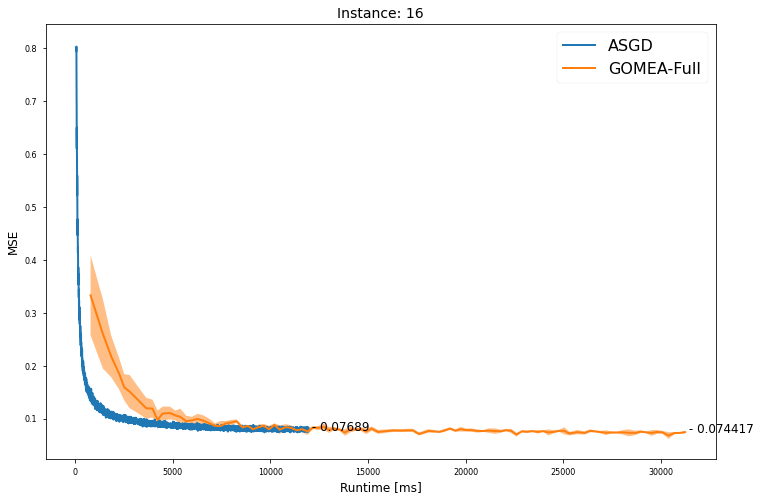

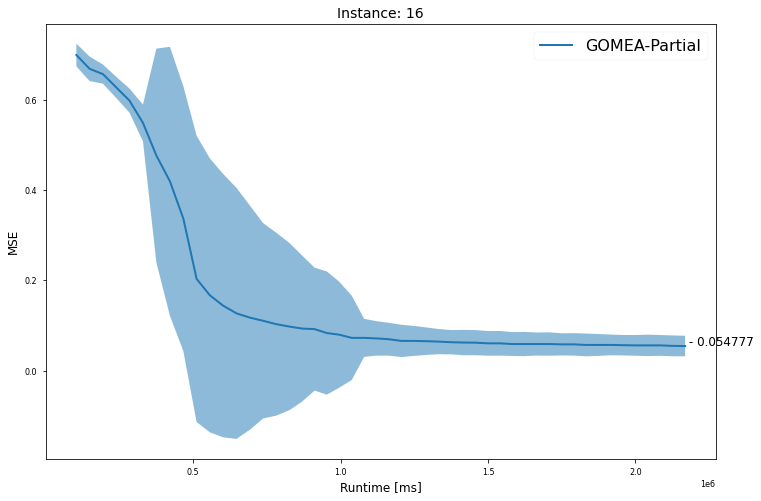

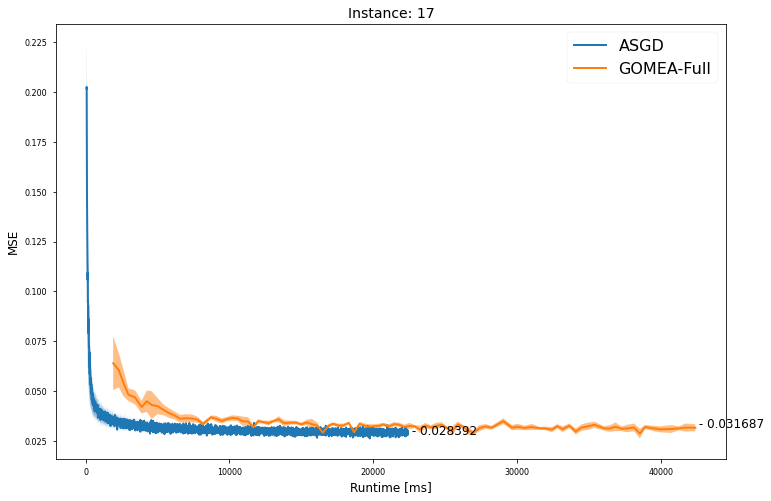

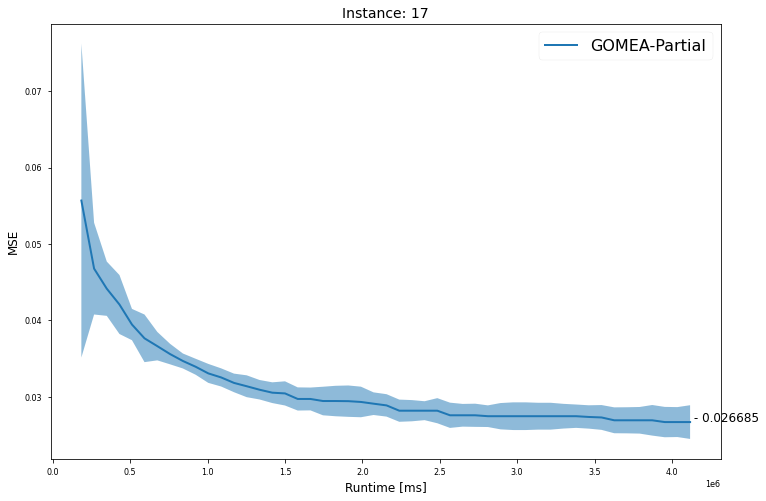

In [119]:
plot_instances()